In [1]:
import gensim
import pandas as pd
import numpy as np
import nltk
import sklearn
import operator
import matplotlib
pd.set_option('display.max_colwidth', -1)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('../data/stop_words_en_long.txt', 'r') as f:
    stop_words = f.read()
stop_words = stop_words.split('\n')

In [4]:
df = pd.read_csv('../../data/classification_training.csv')
df.drop(['url', 'Unnamed: 0', 'Unnamed: 0.1', 'langs'], axis=1, inplace=True)

In [5]:
train, test = sklearn.model_selection.train_test_split(df, test_size=0.2)

# Key Word Approach

The first approach is to take key words that might identify the categories and simply count up their occurences in a text. The decision is made on the majority vote.

In [6]:
df_manual = df.copy()
tokenizer = nltk.tokenize.WordPunctTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

The whole series of texts is tokenized and stemmed.

In [7]:
tokens = df_manual['text'].apply(lambda x: tokenizer.tokenize(x))
tokens = tokens.apply(lambda x: [t.lower() for t in x])
tokens = tokens.apply(lambda x: [t for t in x if len(t) > 2])
stemmed_texts = tokens.apply(lambda x: [stemmer.stem(t) for t in x])

These words were obtained by simply reading through the texts and identifying tokens that might uniquely identify disaster or conflict, or appear many times in those categories.

In [ ]:
train['category'].value_counts()

In [8]:
conflict_tokens = ['war', 'conflict', 'military', 'ceasefire', 'terrorism', 'fighting', 'militia', 'rebels', 
                  'violence', 'violent', 'clash', 'insurgent', 'besiege', 'bomb', 'gun', 'combat', 'siege',
                  'battle', 'battleground', 'explode', 'explosive', 'peace', 'truce', 'airstrike']
conflict_stems = [stemmer.stem(token) for token in conflict_tokens]
disaster_tokens = ['flood', 'wildfire', 'fire', 'earthquake', 'mudslide', 'landslide', 'washed', 'hurricane',
                  'storm', 'rain', 'rainfall', 'river', 'sea', 'disaster', 'volcano', 'typhoon', 'blaze',
                 'tremor', 'drought', 'disease', 'malnutrition', 'virus', 'health', 'tornado', 'forest', 'snow']
disaster_stems = [stemmer.stem(token) for token in disaster_tokens]
print(conflict_stems)
print(disaster_stems)

['war', 'conflict', 'militari', 'ceasefir', 'terror', 'fight', 'militia', 'rebel', 'violenc', 'violent', 'clash', 'insurg', 'besieg', 'bomb', 'gun', 'combat', 'sieg', 'battl', 'battleground', 'explod', 'explos', 'peac', 'truce', 'airstrik']
['flood', 'wildfir', 'fire', 'earthquak', 'mudslid', 'landslid', 'wash', 'hurrican', 'storm', 'rain', 'rainfal', 'river', 'sea', 'disast', 'volcano', 'typhoon', 'blaze', 'tremor', 'drought', 'diseas', 'malnutrit', 'viru', 'health', 'tornado', 'forest', 'snow']


The occurence of each word from the lists are counted and compared.

In [9]:
def tag_by_stem(texts, conflict_stems, disaster_stems):
    equals = []
    categories = []
    tag_dicts = []
    for text in texts:
        tag_dictionary = {'conflict': 0, 'disaster': 0}
        for stem in conflict_stems:
            tag_dictionary['conflict'] = tag_dictionary['conflict'] + text.count(stem)
        for stem in disaster_stems:
            tag_dictionary['disaster'] = tag_dictionary['disaster'] + text.count(stem)
            
        if tag_dictionary['conflict'] == tag_dictionary['disaster']:
            category = 'other'
            e = True
        else:
            category = max(tag_dictionary, key=tag_dictionary.get)
            e = False
        categories.append(category)
        tag_dicts.append(tag_dictionary)
        equals.append(e)
    return categories, tag_dicts, equals

In [10]:
manual_tags, tag_dicts, equals = tag_by_stem(stemmed_texts, conflict_stems, disaster_stems)

In [11]:
print(sklearn.metrics.classification_report(df_manual['category'], manual_tags))

             precision    recall  f1-score   support

   conflict       0.86      0.69      0.77       854
   disaster       0.90      0.89      0.89      1710
      other       0.55      0.71      0.62       683

avg / total       0.82      0.80      0.80      3247



In [12]:
sklearn.metrics.confusion_matrix(df_manual['category'], manual_tags)

array([[ 589,   53,  212],
       [  14, 1516,  180],
       [  82,  114,  487]])

Overall a keyword tagging approach seems to fare reasonably well. The main challenge is misclassification of *disaster* and *conflict* events as *other*.

# Machine Learning Approach

The general machine learning approach used is to convert documents to a TF-IDF representation, and then to mode topcs (or simply reduce dimensionality) by implementing an LSI algorithm. The resulting vectors can then be used in a standard classification technique, such as random forest or SVM.

**Add better text cleaning and combining keyword + ML approaches.**

In [13]:
def prepare_text(text, stop_words):
    tokenizer = nltk.tokenize.WordPunctTokenizer()
    stemmer = nltk.stem.PorterStemmer()
    
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [t for t in tokens if t not in stop_words] 
    stems = [stemmer.stem(t) for t in tokens]
    stems = [s.lower() for s in stems]
    stems = [s for s in stems if not s.isdigit()]
    
    return stems

In [73]:
def regularize(lsi_vecs):
    mean_vec = lsi_vecs.mean(axis=0)
    std_vec = lsi_vecs.std(axis=0)
    for i, vec in enumerate(lsi_vecs):
        lsi_vecs[i] = (mean_vec - vec) / std_vec
    return lsi_vecs

In [67]:
def lsi_to_vecs(corpus_lsi):
    lsi_vecs = []

    for c in corpus_lsi:
        vec = [x[1] for x in c]
        lsi_vecs.append(vec)

    return np.array(lsi_vecs)

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [15]:
train_labels = le.fit_transform(train['category'])

In [188]:
train['category'] = le.fit_transform(train['category'])
test['category'] = le.fit_transform(test['category'])

/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [100]:
train['text'] = train['text'].map(lambda x: prepare_text(x, stop_words))
test['text'] = test['text'].map(lambda x: prepare_text(x, stop_words))

/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [110]:
dictionary = gensim.corpora.Dictionary(train['text'])
corpus = [dictionary.doc2bow(text) for text in train['text']]
tfidf_model = gensim.models.TfidfModel(corpus)

In [115]:
train_corpus_tfidf = tfidf_model[corpus]

### 2D Reduction Inspection

In [141]:
lsi_2d = gensim.models.LsiModel(train_corpus_tfidf, id2word=dictionary, num_topics=2)
corpus_lsi_2d = lsi_2d[train_corpus_tfidf]

In [146]:
topic_0_2d = [x[0][1] for x in corpus_lsi_2d]
topic_1_2d = [x[1][1] for x in corpus_lsi_2d]

From a 2D dimensionality reduction, it looks like there is some significant separation between the three possible categories.

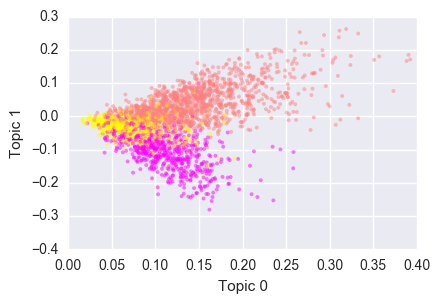

In [248]:
ax = plt.figure(figsize=(4.5,3))
ax = plt.scatter(topic_0_2d, topic_1_2d, c=train_labels, alpha=0.5, s=8, linewidth=0)
plt.set_cmap('spring')
plt.xlim((0, 0.4))
plt.xlabel('Topic 0')
plt.ylabel('Topic 1')

## Full LSI

In [204]:
lsi = gensim.models.LsiModel(train_corpus_tfidf, id2word=dictionary, num_topics=30)
corpus_lsi = lsi[train_corpus_tfidf]

In [16]:
from sklearn import naive_bayes
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Random Forest

In [256]:
param_grid = [{'max_depth': [10, 100, None], 
              'max_features': [4, 5, 6],
              'min_samples_split':[2, 3, 4],
              }]

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
clf = model_selection.GridSearchCV(rf, param_grid=param_grid, cv=5)

In [257]:
clf.fit(lsi_vecs, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [4, 5, 6], 'max_depth': [10, 100, None], 'min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [243]:
test_corpus = [dictionary.doc2bow(text) for text in test['text']]
test_corpus_tfidf = tfidf_model[test_corpus]
test_corpus_lsi = lsi[test_corpus_tfidf]

In [244]:
test_lsi_vecs = lsi_to_vecs(test_corpus_lsi)

In [259]:
clf_best = clf.best_estimator_

In [260]:
predictions = clf_best.predict(test_lsi_vecs)

In [261]:
print(sklearn.metrics.classification_report(test['category'], predictions))

             precision    recall  f1-score   support

          0       0.77      0.81      0.79       168
          1       0.91      0.97      0.94       348
          2       0.73      0.57      0.64       134

avg / total       0.84      0.85      0.84       650



### SVM

In [262]:
param_grid = [{'kernel': ['linear'], 
              'gamma': [.01, .03, 0.1, 0.3, 1.0, 3.0],
              'C': [1/x for x in [.003 , .01, .03, 0.1, 0.3, 1.0, 3.0, 10.0]]}]

svc = svm.SVC()
clf = model_selection.GridSearchCV(svc, param_grid=param_grid, cv=5)

In [263]:
clf.fit(lsi_vecs, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}], 'C': [333.3333333333333, 100.0, 33.333333333333336, 10.0, 3.3333333333333335, 1.0, 0.3333333333333333, 0.1], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [259]:
clf_best = clf.best_estimator_

In [260]:
predictions = clf_best.predict(test_lsi_vecs)

In [261]:
print(sklearn.metrics.classification_report(test['category'], predictions))

             precision    recall  f1-score   support

          0       0.77      0.81      0.79       168
          1       0.91      0.97      0.94       348
          2       0.73      0.57      0.64       134

avg / total       0.84      0.85      0.84       650



# Relevance

**Still needs more work.**

In [17]:
df_relevance = pd.read_csv('../../data/relevance_training.csv')
df_relevance.drop(['Unnamed: 0'], axis=1, inplace=True)

In [18]:
train_relevance, test_relevance = sklearn.model_selection.train_test_split(df_relevance, test_size=0.2)

In [19]:
train_labels = le.fit_transform(train_relevance['is_displacement'])
test_labels = le.fit_transform(test_relevance['is_displacement'])

In [20]:
train_relevance['text'] = train_relevance['text'].map(lambda x: prepare_text(x, stop_words))
test_relevance['text'] = test_relevance['text'].map(lambda x: prepare_text(x, stop_words))

/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [22]:
dictionary_rel = gensim.corpora.Dictionary(train_relevance['text'])
corpus_rel = [dictionary_rel.doc2bow(text) for text in train_relevance['text']]
tfidf_model_rel = gensim.models.TfidfModel(corpus_rel)

In [23]:
train_rel_corpus_tfidf = tfidf_model_rel[corpus_rel]

### 2D Reduction Inspection

In [24]:
lsi_rel_2d = gensim.models.LsiModel(train_rel_corpus_tfidf, id2word=dictionary_rel, num_topics=2)
corpus_rel_lsi_2d = lsi_rel_2d[train_rel_corpus_tfidf]

In [25]:
topic_0_2d = [x[0][1] for x in corpus_rel_lsi_2d]
topic_1_2d = [x[1][1] for x in corpus_rel_lsi_2d]

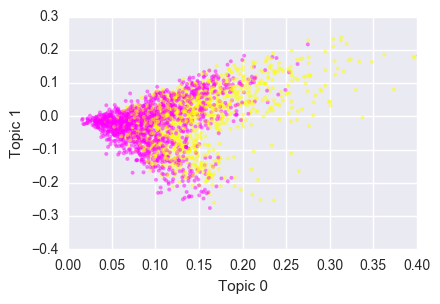

In [26]:
ax = plt.figure(figsize=(4.5,3))
ax = plt.scatter(topic_0_2d, topic_1_2d, c=train_labels, alpha=0.5, s=8, linewidth=0)
plt.set_cmap('spring')
plt.xlim((0, 0.4))
plt.xlabel('Topic 0')
plt.ylabel('Topic 1')

## SVM

In [68]:
lsi_rel = gensim.models.LsiModel(train_rel_corpus_tfidf, id2word=dictionary_rel, num_topics=30)
corpus_rel_lsi = lsi_rel[train_rel_corpus_tfidf]

In [74]:
lsi_vecs_rel = regularize(lsi_to_vecs(corpus_rel_lsi))

In [75]:
param_grid = [{'kernel': ['linear'], 
              'gamma': [.01, .03, 0.1, 0.3, 1.0, 3.0],
              'C': [1/x for x in [.003 , .01, .03, 0.1, 0.3, 1.0, 3.0, 10.0]]}]

svc = svm.SVC()
clf = model_selection.GridSearchCV(svc, param_grid=param_grid, cv=5)

In [ ]:
clf.fit(lsi_vecs_rel, train_labels)

In [ ]:
clf_best = clf.best_estimator_

#### Predictions

In [ ]:
test_corpus_rel = [dictionary_rel.doc2bow(text) for text in test_relevance['text']]
test_corpus_tfidf_rel = tfidf_model_rel[test_corpus_rel]
test_corpus_lsi_rel = lsi_rel[test_corpus_tfidf_rel]
test_lsi_vecs_rel = regularize(lsi_to_vecs(test_corpus_lsi_rel))

In [ ]:
predictions = clf_best.predict(test_lsi_vecs_rel)

In [ ]:
print(sklearn.metrics.classification_report(test_labels, predictions))